In [3]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import arviz as az

# setting random seed for reproducibility
random_seed = 31765
rng = np.random.default_rng(random_seed)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Section I: Coin toss in PyMC

We flip a coin $n=50$ times. This has (unknown to us) probability $\theta=0.8$ to show heads after one toss. We observe a total of $k$ times head.

In [5]:
# set true parameters
n = 50
theta_true = 0.8

In [6]:
# create data
k = rng.binomial(n, theta_true)
print(f"We observed k={k} times head.")

We observed k=38 times head.


## Prior

If we want to solve the problem with Bayesian inference, we have to specify a prior. Since we assume a normal coin, we take a beta distribution with $\alpha=3$ and $\beta=3$, which is thus concentrated by 0.5.

Text(0.5, 1.0, 'Prior Distribution')

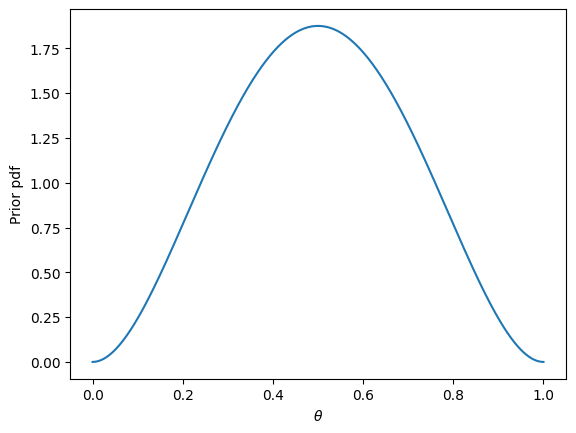

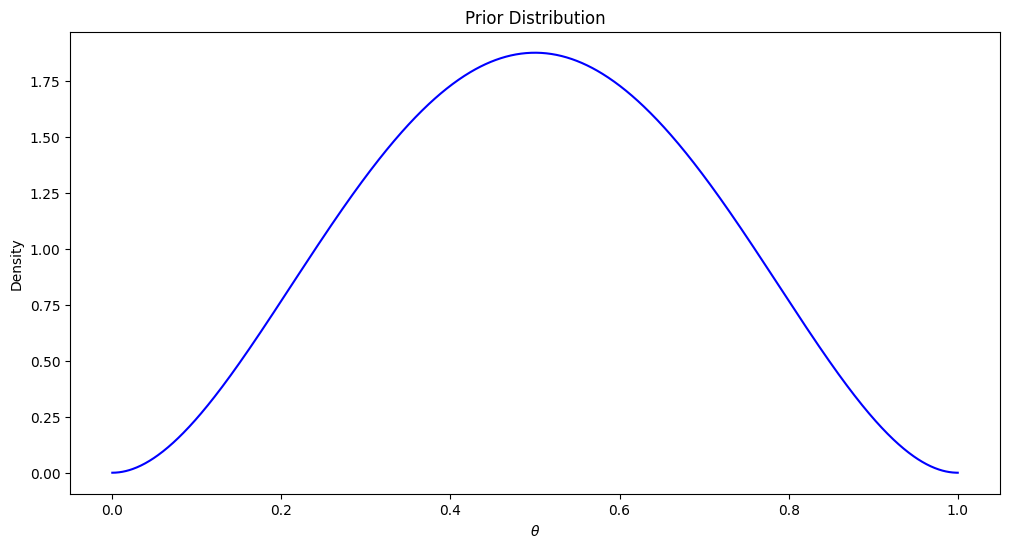

In [7]:
x = np.linspace(0,1,1000)
alpha = 3
beta = 3
y = scipy.stats.beta.pdf(x, a=alpha, b=beta)
plt.xlabel(r"$\theta$")
plt.ylabel("Prior pdf")
plt.plot(x,y);

plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Prior', color='blue')
plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.title("Prior Distribution")

## Coin model

We create a PyMC model for this Bayesian inference, using our Beta prior and the Binomial likelihood.

In the first line, a new *Model* object is created, which serves us as a container for the random variables. Using the *with* statement we can create a context manager, which allows us to fill and manipulate this container within an indented code block.

 Then we create a random variable for the prior over $\theta$. For this we use the Beta distribution of the PyMC module. The first parameter is always the name of the variable (by convention, this is chosen to be identical to the variable identifier (the string given as the first argument), it becomes relevant when PyMC creates outputs and summaries). This is followed by the parameters of the distribution, in our case $\alpha$ and $\beta$.

 At the end we specify the likelihood, which is Binomial in our case. We know the value of $n$ and can pass it directly to the Binomial distribution. The value of $\theta$ is to be inferred, so we pass the random variable from the previous step at this point. This is followed by the *observed* parameter, which is passed the data. In our case this is the number of observed head throws, which we know as $k$.

In [8]:
coin_model = pm.Model()

with coin_model:
    # prior
    theta = pm.Beta("theta", alpha=alpha, beta=beta)
    # likelihood
    k_observed = pm.Binomial("k_observed", n=n, p=theta, observed=k)

We have now created our first PyMC model and can infer the value of $\theta$. Specifically, this means that we can now compute the posterior without calculating it analytically. So we use sampling to determine an approximation of the distribution.

Here we want to draw 1000 samples of the posterior distribution, which is done in PyMC as follows:

In [20]:
with coin_model:
    coin_idata = pm.sample(1000, chains=4, return_inferencedata=False)
    print(coin_idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<MultiTrace: 4 chains, 1000 iterations, 2 variables>


The parameter *chains* is optional and specifies how often we want to run these 1000 samples. In practice, it is often helpful to set this higher (so you repeat the sampling procedure to check for random variations), but for illustration purposes we are only sampling 1000 samples once here.

(array([0.0292497 , 0.0292497 , 0.        , 0.        , 0.        ,
        0.0292497 , 0.0292497 , 0.0292497 , 0.0584994 , 0.11699879,
        0.0584994 , 0.11699879, 0.32174668, 0.23399759, 0.35099638,
        0.61424367, 0.84824125, 1.19923763, 1.52098432, 1.93048009,
        2.51547406, 2.19372738, 2.95421954, 3.45146441, 3.48071411,
        5.03094812, 4.29970566, 5.79144028, 5.64519179, 6.08393726,
        6.58118213, 6.43493364, 6.52268274, 6.43493364, 7.40017369,
        5.73294088, 5.26494571, 4.97244872, 4.50445355, 3.68546199,
        2.66172255, 2.22297708, 1.69648251, 1.16998793, 1.25773703,
        0.61424367, 0.58499397, 0.11699879, 0.0877491 , 0.0877491 ]),
 array([0.4645108 , 0.47305789, 0.48160499, 0.49015209, 0.49869918,
        0.50724628, 0.51579338, 0.52434047, 0.53288757, 0.54143467,
        0.54998176, 0.55852886, 0.56707596, 0.57562305, 0.58417015,
        0.59271725, 0.60126434, 0.60981144, 0.61835854, 0.62690563,
        0.63545273, 0.64399983, 0.65254692, 0.

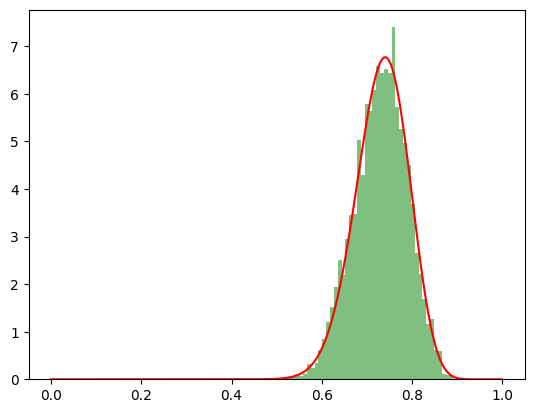

In [21]:
# analytical
alpha_post = alpha + k
beta_post = beta + n - k
y_post = scipy.stats.beta.pdf(x, a=alpha_post, b=beta_post)

plt.plot(x, y_post, label='Analytical Posterior', color='red')

# numerical
theta_samples = coin_idata['theta']
plt.hist(theta_samples, bins=50, density=True, alpha=0.5, label='Numerical Posterior', color='green')


Of course, we can also look at the posterior distribution now, using the Python module ArviZ. On the left you can see the plot of the approximate posterior over $\theta$. On the right you can see the so-called chain. For each of the 1000 samples you can see the corresponding value on the y-axis. The left plot is a kind of histogram over the right plot. The chain can be helpful to check that your inference is converged. It should look like a ``fat caterpillar''.

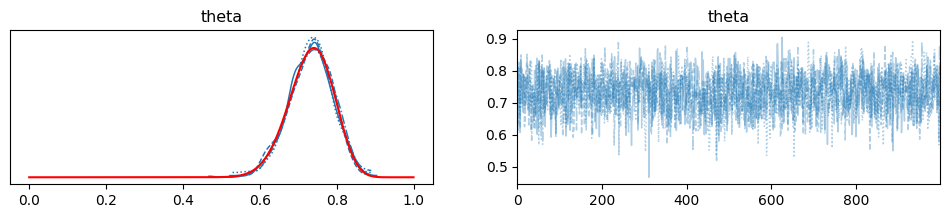

In [16]:
ax = az.plot_trace(coin_idata)
# ax[0,0] is the left one, so just add your posterior x and y values inside the parenthesis
ax[0,0].plot(x, y_post, color='red', label='Analytical Posterior')

Statistics about the posterior like mean, standard deviations but also credible intervals can be generated as follows:

In [17]:
with coin_model:
    display(az.summary(coin_idata, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.73,0.06,0.62,0.83,0.0,0.0,1894.61,2729.33,1.0


You can also determine the MAP (maximum a posteriori, i.e. the mode of posterior distribution) via:

In [19]:
# Calculate MAP estimates
# Analytical MAP
if alpha_post > 1 and beta_post > 1:
    map_analytical = (alpha_post - 1) / (alpha_post + beta_post - 2)
else:
    map_analytical = 0 if alpha_post <= 1 else 1

print(f"Analytical MAP: {map_analytical}")

# Numerical MAP 
map_numerical = pm.find_MAP(model=coin_model)["theta"]
print(f"Numerical MAP: {map_numerical}")

Analytical MAP: 0.7407407407407407


Output()

Numerical MAP: 0.7407407067576961


# 1.4 What is the influence of the number of samples for the posterior? Try different values, include plots and describe the effect.

The number of samples in MCMC (Markov Chain Monte Carlo) sampling affects the quality and stability of the posterior distribution estimates. More samples typically lead to more accurate and reliable estimates, but at the cost of increased computation time.

To explore this effect, we'll run the PyMC3 model with different numbers of samples and compare the resulting posterior distributions. We'll use 500, 2000, and 5000 samples and visualize the posterior distributions for each case.


We observed k=44 times head.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 12 seconds.


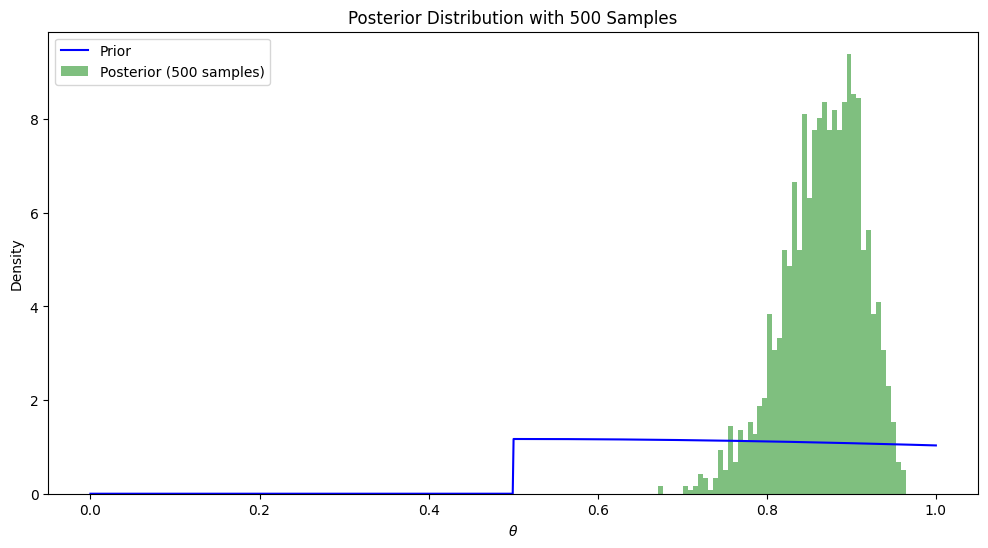

ValueError: Can only convert xarray dataarray, xarray dataset, dict, pytree, netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not MultiTrace

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pymc as pm
import arviz as az

# Step 1: Generate observed data
n = 50
theta_true = 0.8
rng = np.random.default_rng()
k = rng.binomial(n, theta_true)
print(f"We observed k={k} times head.")

# Step 2: Define the prior
x = np.linspace(0, 1, 1000)
mu = 0.5
sigma = 1
y = scipy.stats.truncnorm.pdf(x, a=0, b=1, loc=mu, scale=sigma)

plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Prior', color='blue')
plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.title("Prior Distribution (Truncated Normal)")

# Function to run the model and plot results
def run_model_and_plot(num_samples):
    coin_model = pm.Model()

    with coin_model:
        # prior
        theta = pm.TruncatedNormal("theta", mu=mu, sigma=sigma, lower=0, upper=1)
        # likelihood
        k_observed = pm.Binomial("k_observed", n=n, p=theta, observed=k)
        # perform MCMC sampling with multiple chains
        trace = pm.sample(num_samples, chains=4, return_inferencedata=False)
        
    # Convert the trace to InferenceData object for Arviz
    # coin_idata = az.from_pymc3(trace)
    
    # Plot the posterior
    theta_samples = trace['theta']
    plt.hist(theta_samples, bins=50, density=True, alpha=0.5, label=f'Posterior ({num_samples} samples)', color='green')
    plt.xlabel(r"$\theta$")
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"Posterior Distribution with {num_samples} Samples")
    plt.show()
    
    # Plot trace with Arviz
    az.plot_trace(coin_idata)
    plt.show()
    
    # Calculate MAP estimate using PyMC3
    map_numerical = pm.find_MAP(model=coin_model)["theta"]
    print(f"Numerical MAP with {num_samples} samples: {map_numerical}")

# Run the model and plot results for different numbers of samples
for num_samples in [500, 2000, 5000]:
    run_model_and_plot(num_samples)


# Explanation:
## Data Generation: 
Generate the observed data k using a binomial distribution.
## Prior Definition: 
Define the prior distribution for 'theta' using a truncated normal distribution with μ = 0.5 and σ=1, and plot it.
## Function to Run the Model and Plot Results: 
Define a function run_model_and_plot that sets up the PyMC model, performs MCMC sampling with a specified number of samples, plots the posterior distribution, plots the trace using Arviz, and calculates the MAP estimate.
## Run the Model and Plot Results for Different Numbers of Samples: 
Run the run_model_and_plot function with 500, 2000, and 5000 samples, and compare the results.

# Observations:
## Posterior Distribution: 
As the number of samples increases, the posterior distribution becomes smoother and more stable. With fewer samples (e.g., 500), the posterior might appear more jagged and less reliable.
## Trace Plots: 
With more samples, the trace plots show better mixing and convergence of the chains, indicating more reliable posterior estimates.


## MAP Estimate: 
The MAP estimate becomes more stable and accurate with an increasing number of samples.
By running this code, you will generate plots and observe how the posterior distribution, trace plots, and MAP estimates vary with the number of samples. This will help you understand the trade-off between computation time and the quality of the posterior estimates.

# Section II: Gaussian model in PyMC
Next, we will take a look at normally distributed observations and start with the case, where the variance is known.

Assume you want to measure the average IQ of people in this course. We know that IQ values are normally distributed with a standard deviation of 15, but we want to infer what the mean is.

First, we generate our observed data.

In [28]:
# set true parameters
mu_true = 100
sigma = 15

In [29]:
# sample test results
iq_data = rng.normal(mu_true, sigma, size=25)

## Prior
First, we want to use the conjugate prior distribution, which we have learned in week 5 is a normal distribution.

We might assume that people at the university have a higher IQ than the average person, so choose a prior with $\mu$=110, but since we are not very sure about it, choose a standard deviation of $\sigma$=25.

In [35]:
mu_prior = 110
sigma_prior = 25

# Step 3: Set up the PyMC model
iq_model = pm.Model()

with iq_model:
    # Prior
    mu = pm.Normal("mu", mu=mu_prior, sigma=sigma_prior)
    # Likelihood
    observed_data = pm.Normal("observed_data", mu=mu, sigma=sigma, observed=iq_data)
    # Perform MCMC sampling
    trace = pm.sample(2000, chains=4)

# Step 4: Convert the trace to InferenceData object for Arviz
iq_idata = az.from_pymc(trace)

# Step 5: Plot the prior and posterior distributions
x = np.linspace(70, 150, 1000)
prior_y = scipy.stats.norm.pdf(x, loc=mu_prior, scale=sigma_prior)

plt.figure(figsize=(12, 6))
plt.plot(x, prior_y, label='Prior', color='blue')
plt.hist(trace.posterior['mu'].values.flatten(), bins=50, density=True, alpha=0.5, label='Posterior', color='green')
plt.xlabel(r"$\mu$")
plt.ylabel("Density")
plt.title("Prior and Posterior Distributions")
plt.legend()
plt.show()

# Step 6: Plot trace with Arviz
az.plot_trace(iq_idata)
plt.show()

# Calculate MAP estimate using PyMC
map_numerical = pm.find_MAP(model=iq_model)['mu']
print(f"Numerical MAP: {map_numerical}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


AttributeError: module 'arviz' has no attribute 'from_pymc'

## PyMC model
After having specified our prior and likelihood, we want to run inference over the mean value of our observations.

Specify the model in PyMC. Feel free to orientate yourself to the model, you have seen in Section I.

Since your prior and your likelihood are normal distributions, you might want to take a look at the [Documentation of PyMC's normal distribution](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Normal.html). 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


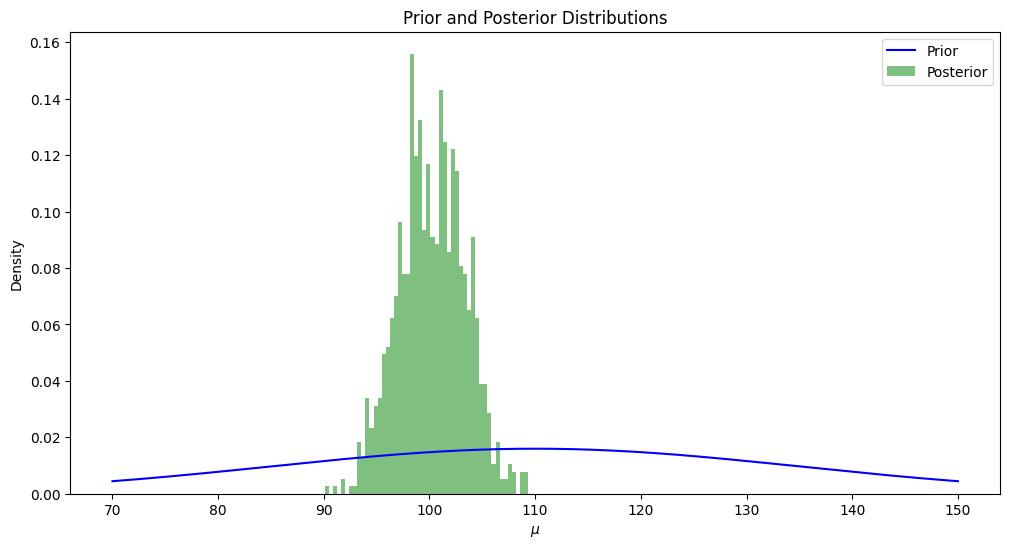

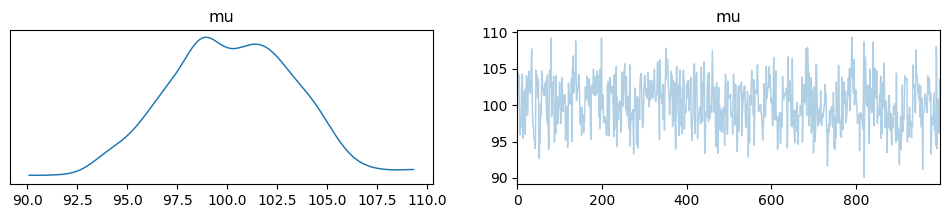


Numerical MAP: 100.25826237570757


In [36]:
iq_model = pm.Model()

with iq_model:
    # Prior for the mean
    mu = pm.Normal("mu", mu=mu_prior, sigma=sigma_prior)
    # Likelihood (sampling distribution) of observations
    observed_data = pm.Normal("observed_data", mu=mu, sigma=sigma, observed=iq_data)

# Step 4: Perform MCMC sampling
with iq_model:
    iq_idata = pm.sample(1000, chains=1)

# Step 5: Convert the trace to InferenceData object for Arviz
# iq_idata = az.from_pymc3(trace) # This is done automatically now

# Step 6: Plot the prior and posterior distributions
x = np.linspace(70, 150, 1000)
prior_y = scipy.stats.norm.pdf(x, loc=mu_prior, scale=sigma_prior)

plt.figure(figsize=(12, 6))
plt.plot(x, prior_y, label='Prior', color='blue')
plt.hist(iq_idata.posterior['mu'].values.flatten(), bins=50, density=True, alpha=0.5, label='Posterior', color='green')
plt.xlabel(r"$\mu$")
plt.ylabel("Density")
plt.title("Prior and Posterior Distributions")
plt.legend()
plt.show()

# Step 7: Plot trace with Arviz
az.plot_trace(iq_idata)
plt.show()

# Calculate MAP estimate using PyMC
with iq_model:
    map_numerical = pm.find_MAP()
print(f"Numerical MAP: {map_numerical['mu']}")

In [37]:
with iq_model:
    iq_idata = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


To validate the results of the PyMC sampling process, write down the analytical posterior distribution and plot the two distributions in comparison.

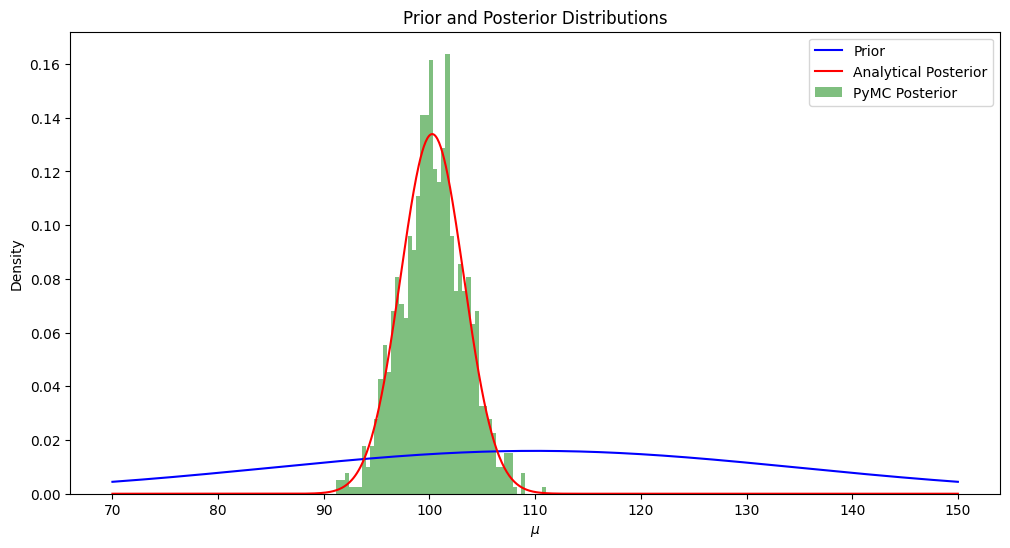

In [38]:
# Analytical posterior calculation
n = len(iq_data)
mu_posterior = (mu_prior / sigma_prior**2 + np.sum(iq_data) / sigma**2) / (1 / sigma_prior**2 + n / sigma**2)
sigma_posterior = np.sqrt(1 / (1 / sigma_prior**2 + n / sigma**2))

# Step 5: Plot the prior and posterior distributions
x = np.linspace(70, 150, 1000)
prior_y = scipy.stats.norm.pdf(x, loc=mu_prior, scale=sigma_prior)
posterior_y = scipy.stats.norm.pdf(x, loc=mu_posterior, scale=sigma_posterior)

plt.figure(figsize=(12, 6))
plt.plot(x, prior_y, label='Prior', color='blue')
plt.plot(x, posterior_y, label='Analytical Posterior', color='red')
plt.hist(iq_idata.posterior['mu'].values.flatten(), bins=50, density=True, alpha=0.5, label='PyMC Posterior', color='green')
plt.xlabel(r"$\mu$")
plt.ylabel("Density")
plt.title("Prior and Posterior Distributions")
plt.legend()
plt.show()

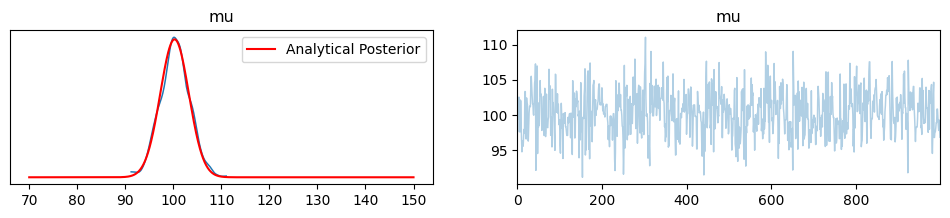


Numerical MAP: 100.25826237570757


In [39]:
ax = az.plot_trace(iq_idata)
ax[0,0].plot(x, posterior_y, label='Analytical Posterior', color='red')
ax[0,0].legend()
plt.show()

# Calculate MAP estimate using PyMC
with iq_model:
    map_numerical = pm.find_MAP()
print(f"Numerical MAP: {map_numerical['mu']}")

Next, repeat the above analysis for the model with unknown variance. To do that, please define a prior distribution over $\sigma^2$, adjust the PyMC model, and plot the marginal posterior distributions for both of your latent variables.  

Since you are free to choose any prior for $\sigma^2$, you do not have to compare the result with the analytical solution.

# Section III: Cheat detection
Social data has an additional layer of interest as people are not always honest with responses, which adds a further complication into inference. For example, simply asking individuals "Have you ever cheated on a test?" will surely contain some rate of dishonesty. What you can say for certain is that the true rate is less than your observed rate (assuming individuals lie only about not cheating; I cannot imagine one who would admit "Yes" to cheating when in fact they hadn't cheated).

We will use the binomial distribution to determine the frequency of students cheating during an exam. If we let N be the total number of students who took the exam, and assuming each student is interviewed post-exam (answering without consequence), we will receive integer X "Yes I did cheat" answers. We then find the posterior distribution of p, given N, some specified prior on p, and observed data X.

This is a completely absurd model. No student, even with a free-pass against punishment, would admit to cheating. What we need is a better algorithm to ask students if they had cheated. Ideally the algorithm should encourage individuals to be honest while preserving privacy. The following proposed algorithm is a possible solution:

In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes" was the result of a guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers.

Suppose 100 students are being surveyed for cheating, and we wish to find p, the probability that a student has cheated during the exam, given that 42 of them answered yes.

## Prior
First, start by defining the prior over the probability that a student has indeed cheated.

Since the likelihood above does not have a conjugate prior distribution, you are free to choose any probability distribution, but explain why you have chosen which distribution and parameterization.

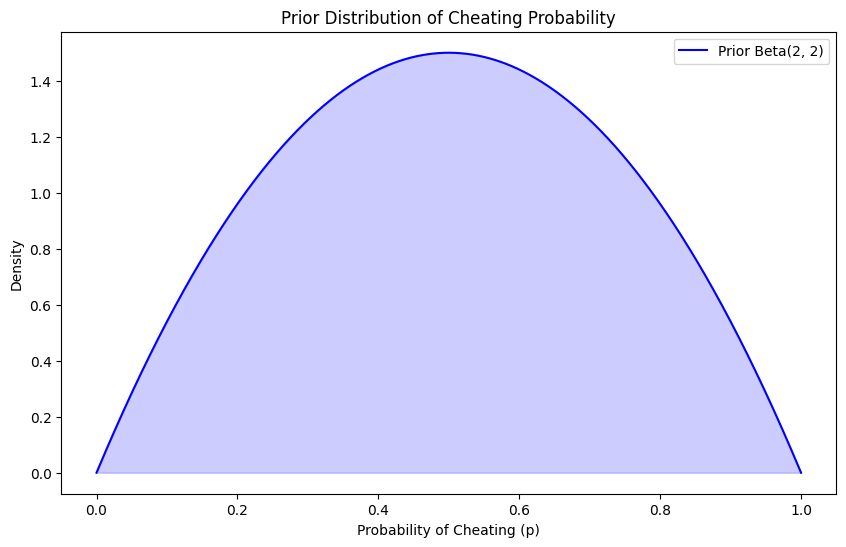

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Define the parameters for the Beta prior
alpha_prior = 2
beta_prior = 2

# Generate a range of p values
p_values = np.linspace(0, 1, 1000)

# Compute the prior distribution
prior_distribution = stats.beta.pdf(p_values, alpha_prior, beta_prior)

# Plot the prior distribution
plt.figure(figsize=(10, 6))
plt.plot(p_values, prior_distribution, label='Prior Beta(2, 2)', color='blue')
plt.fill_between(p_values, prior_distribution, alpha=0.2, color='blue')
plt.xlabel('Probability of Cheating (p)')
plt.ylabel('Density')
plt.title('Prior Distribution of Cheating Probability')
plt.legend()
plt.show()


In [41]:
import pymc as pm
import arviz as az

# Number of students surveyed
N = 100

# Number of "Yes" responses
X = 42

# Set up the PyMC model
with pm.Model() as cheating_model:
    # Prior for the probability of cheating
    p = pm.Beta('p', alpha=alpha_prior, beta=beta_prior)

    # Likelihood
    # The observed "Yes" responses can be modeled using a Binomial distribution
    # The probability of answering "Yes" in the interview process
    p_yes = 0.5 * p + 0.25
    X_obs = pm.Binomial('X_obs', n=N, p=p_yes, observed=X)

    # Perform MCMC sampling
    trace = pm.sample(2000, chains=2, tune=1000)

# Convert the trace to an InferenceData object for Arviz
idata = az.from_pymc(trace)

# Plot the posterior distribution
az.plot_posterior(idata, var_names=['p'], hdi_prob=0.95)
plt.show()

# Print the summary of the posterior
print(az.summary(idata, var_names=['p'], hdi_prob=0.95))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


AttributeError: module 'arviz' has no attribute 'from_pymc'

## PyMC model
After having defined the prior, implement the model in PyMC and infer the posterior over the probability of a student having cheated.

Draw as much samples until you feel that the posterior has converged to a stable distribution.

In [ ]:
num_students = 100
num_yes = 42

In [44]:
import pymc as pm

# Define the PyMC model
cheat_model = pm.Model()

with cheat_model:
    # Prior for the probability of cheating
    p = pm.Beta('p', alpha=2, beta=2)
    
    # Likelihood
    # The observed "Yes" responses can be modeled using a Binomial distribution
    X_obs = pm.Binomial('X_obs', n=num_students, p=p, observed=num_yes)
    
    # Perform MCMC sampling
    trace = pm.sample(5000, chains=4, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


# 4

The prior predictive distribution and posterior predictive distribution are essential concepts in Bayesian statistics, used for different stages of the modeling process to validate and assess the performance of Bayesian models.

## Prior Predictive Distribution:

The prior predictive distribution represents the distribution of observable data implied by the prior distribution of model parameters. It quantifies our uncertainty about the data before observing any actual data.
In simpler terms, it tells us what kind of data we expect to observe given our prior beliefs about the parameters of the model.
It is used to simulate data from the model under the prior assumptions. This simulation allows us to understand the range of possible data that the model could generate before observing any real data.
By comparing the simulated data with observed data, we can assess whether our prior assumptions about the model parameters are reasonable and whether the model structure itself is appropriate for the problem at hand.

## Posterior Predictive Distribution:

The posterior predictive distribution represents the distribution of observable data implied by the posterior distribution of model parameters after observing the actual data.
It quantifies our updated uncertainty about the data after incorporating the information from the observed data.
It is used to simulate data from the model under the posterior distribution of parameters. This simulation allows us to understand the range of possible data that the model could generate given the observed data.
By comparing the simulated data with the observed data, we can assess whether the model captures the patterns and variability present in the observed data.
In PyMC, you can implement prior and posterior predictive distributions using the pm.sample_prior_predictive and pm.sample_posterior_predictive functions, respectively. These functions generate samples of observable data from the model under the prior or posterior distributions of parameters.

For example, consider the following steps to implement and use prior and posterior predictive distributions in PyMC:

## Define a Bayesian model using PyMC:

Define the prior distributions for model parameters.
Define the likelihood function based on the observed data.
Sample from the prior predictive distribution:

Use pm.sample_prior_predictive to generate samples of observable data from the model under the prior distributions of parameters.
Compare the simulated data with any available prior information or expert knowledge to validate the model assumptions.
Sample from the posterior predictive distribution:

Use pm.sample_posterior_predictive after fitting the model to observed data to generate samples of observable data from the model under the posterior distributions of parameters.
Compare the simulated data with the observed data to assess the model's ability to capture the observed patterns and variability.
By comparing the simulated data from the prior and posterior predictive distributions with observed data, we can evaluate the model's fit, identify potential model misspecifications, and refine our understanding of the underlying processes. This iterative process helps in building and refining Bayesian models for making reliable predictions and inferences.